## Import Datasets

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from scipy.io import wavfile

# Define a custom class to store audio data
class AudioFile:
    def __init__(self, file_name, audio_data, sample_rate, label):
        self.file_name = file_name   # Unique Idenfifier
        self.audio_data = audio_data
        self.sample_rate = sample_rate
        self.label = label

    def __repr__(self):
        return f"AudioFile(file_name={self.file_name}, label={self.label}, sample_rate={self.sample_rate}, audio_data_shape={self.audio_data.shape})"

# Path to the folder containing .wav files
folder_path = "cats_dogs"

# List all .wav files in the folder
wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

# Create a list to store AudioFile objects
audio_objects = []

# Load each .wav file and store as an AudioFile object
for wav_file in wav_files:
    file_path = os.path.join(folder_path, wav_file)
    sr, y = wavfile.read(file_path)  # sr: sample rate, y: audio data
    y = y.astype(np.float32) / np.iinfo(y.dtype).max
    # print(f"Loaded {wav_file} with sample rate {sr} and {len(y)} samples")

    if wav_file.startswith("cat"):
        label = "cat"
    elif wav_file.startswith("dog_barking"):
        label = "dog_barking"
    else:
        label = ""
    # Create an AudioFile object and store it
    audio_objects.append(AudioFile(wav_file, y, sr, label))

# Check first 5 Audio Files
for audio_object in audio_objects[:5]:
    print(audio_object)

AudioFile(file_name=cat_1.wav, label=cat, sample_rate=16000, audio_data_shape=(179200,))
AudioFile(file_name=cat_10.wav, label=cat, sample_rate=16000, audio_data_shape=(150208,))
AudioFile(file_name=cat_100.wav, label=cat, sample_rate=16000, audio_data_shape=(20696,))
AudioFile(file_name=cat_101.wav, label=cat, sample_rate=16000, audio_data_shape=(184000,))
AudioFile(file_name=cat_102.wav, label=cat, sample_rate=16000, audio_data_shape=(182400,))


## Visualize Waveform

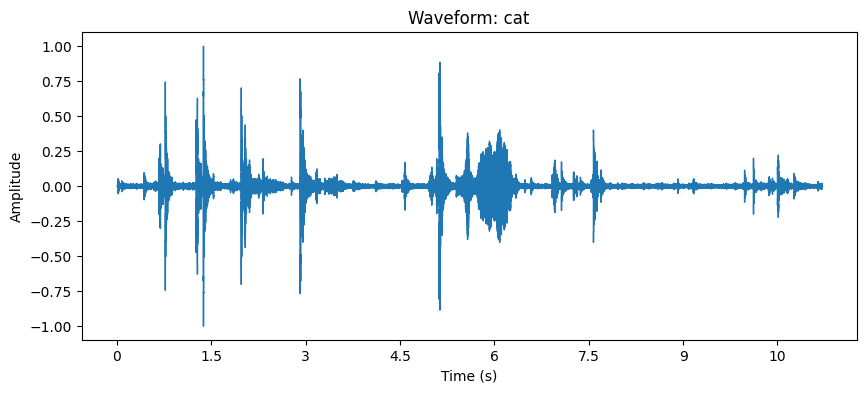

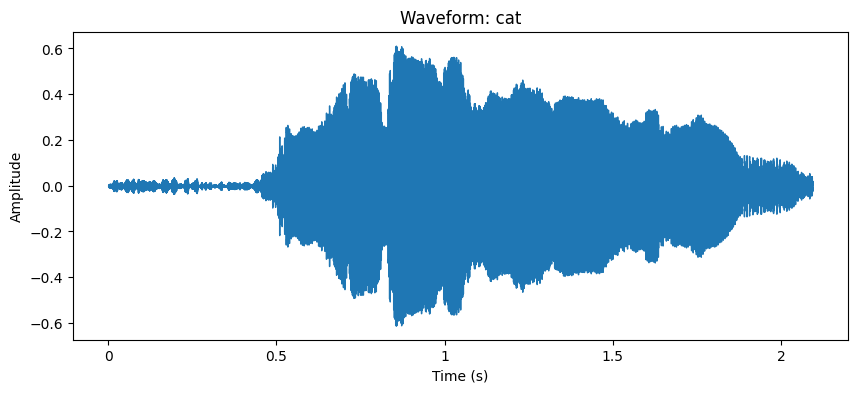

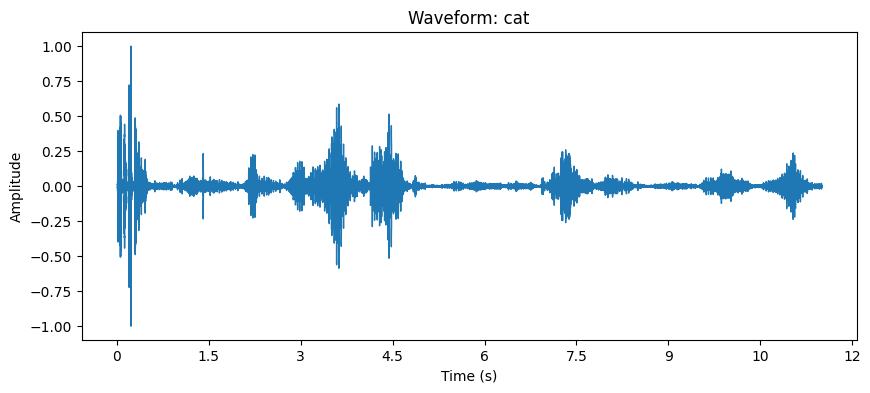

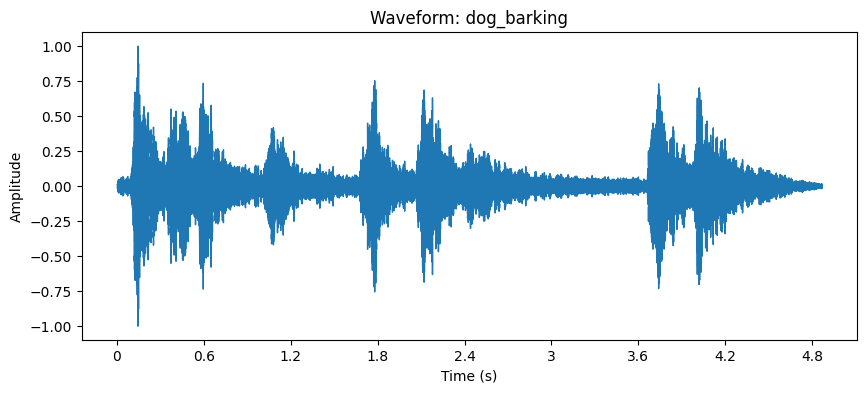

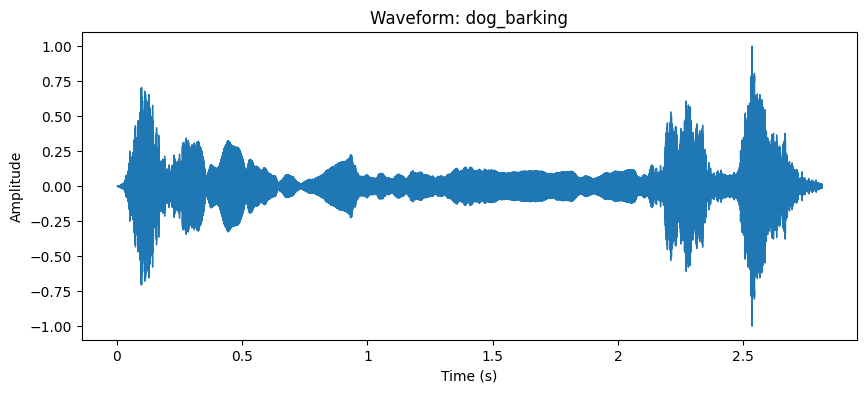

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Sample every 75th audio object
for sample in audio_objects[::60]:
    y = sample.audio_data
    sr = sample.sample_rate
    
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {sample.label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

## Data Preprocessing
Goals:<br>
(1) Convert list of audio files into a dataframe<br>
(2) Extract MFCC<br>
(3) Split train/test<br>

### Convert list of AudioFile objects into dataframe

In [4]:
# Features of interest:
# (file_name, label, audio_data, sample_rate)

# Convert to DataFrame
data = {
    "file_name": [audio_object.file_name for audio_object in audio_objects],
    "audio_data": [audio_object.audio_data for audio_object in audio_objects],
    "sample_rate": [audio_object.sample_rate for audio_object in audio_objects],
    "label": [audio_object.label for audio_object in audio_objects]
}

audio_df = pd.DataFrame(data)

# Display the DataFrame
print(audio_df)

              file_name                                         audio_data  \
0             cat_1.wav  [0.0037842952, 0.0032654805, 0.00021362957, -0...   
1            cat_10.wav  [-0.00024414808, 0.0, 0.00012207404, -0.000396...   
2           cat_100.wav  [-0.007843257, -0.00839259, -0.0077517014, -0....   
3           cat_101.wav  [-0.0024109622, -0.0042725913, -0.0039979247, ...   
4           cat_102.wav  [-0.006286813, -0.001678518, 0.0036622211, 0.0...   
..                  ...                                                ...   
272  dog_barking_95.wav  [0.0009460738, 0.0003662221, -0.00018311106, -...   
273  dog_barking_96.wav  [-0.0032654805, -0.003173925, -0.0030823695, -...   
274  dog_barking_97.wav  [-0.0006714072, -0.0009155553, -0.0009155553, ...   
275  dog_barking_98.wav  [-3.051851e-05, -3.051851e-05, 0.0, 0.0, -3.05...   
276  dog_barking_99.wav  [-0.00054933317, -0.0019226661, -0.0046388134,...   

     sample_rate        label  
0          16000          cat  

In [5]:
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_name    277 non-null    object
 1   audio_data   277 non-null    object
 2   sample_rate  277 non-null    int64 
 3   label        277 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.8+ KB


In [6]:
# Function to extract MFCC features
def extract_mfcc(audio_data, sample_rate, n_mfcc=13):
    return librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)

# Add MFCC features to the DataFrame
audio_df["mfcc"] = audio_df.apply(lambda row: extract_mfcc(row["audio_data"], row["sample_rate"]), axis=1)

# Display the DataFrame
print(audio_df)

              file_name                                         audio_data  \
0             cat_1.wav  [0.0037842952, 0.0032654805, 0.00021362957, -0...   
1            cat_10.wav  [-0.00024414808, 0.0, 0.00012207404, -0.000396...   
2           cat_100.wav  [-0.007843257, -0.00839259, -0.0077517014, -0....   
3           cat_101.wav  [-0.0024109622, -0.0042725913, -0.0039979247, ...   
4           cat_102.wav  [-0.006286813, -0.001678518, 0.0036622211, 0.0...   
..                  ...                                                ...   
272  dog_barking_95.wav  [0.0009460738, 0.0003662221, -0.00018311106, -...   
273  dog_barking_96.wav  [-0.0032654805, -0.003173925, -0.0030823695, -...   
274  dog_barking_97.wav  [-0.0006714072, -0.0009155553, -0.0009155553, ...   
275  dog_barking_98.wav  [-3.051851e-05, -3.051851e-05, 0.0, 0.0, -3.05...   
276  dog_barking_99.wav  [-0.00054933317, -0.0019226661, -0.0046388134,...   

     sample_rate        label  \
0          16000          cat 

In [7]:
# Flatten MFCC features into separate columns
mfcc_flattened = [mfcc.flatten() for mfcc in audio_df["mfcc"]]

# Determine the maximum number of MFCC coefficients
max_mfcc_length = max(len(mfcc) for mfcc in mfcc_flattened)

# Create a DataFrame with flattened MFCC features
mfcc_columns = [f"mfcc_{i}" for i in range(max_mfcc_length)]
mfcc_data = {col: [] for col in mfcc_columns}

for mfcc in mfcc_flattened:
    for i, value in enumerate(mfcc):
        mfcc_data[f"mfcc_{i}"].append(value)
    # Pad with NaN if necessary
    for i in range(len(mfcc), max_mfcc_length):
        mfcc_data[f"mfcc_{i}"].append(np.nan)

# Add flattened MFCC features to the original DataFrame
df_mfcc = pd.concat([audio_df, pd.DataFrame(mfcc_data)], axis=1)

# Drop the original "mfcc" column (optional)
df_mfcc = df_mfcc.drop(columns=["mfcc"])

# Display the DataFrame
print(df_mfcc)
print(df_mfcc.info())

              file_name                                         audio_data  \
0             cat_1.wav  [0.0037842952, 0.0032654805, 0.00021362957, -0...   
1            cat_10.wav  [-0.00024414808, 0.0, 0.00012207404, -0.000396...   
2           cat_100.wav  [-0.007843257, -0.00839259, -0.0077517014, -0....   
3           cat_101.wav  [-0.0024109622, -0.0042725913, -0.0039979247, ...   
4           cat_102.wav  [-0.006286813, -0.001678518, 0.0036622211, 0.0...   
..                  ...                                                ...   
272  dog_barking_95.wav  [0.0009460738, 0.0003662221, -0.00018311106, -...   
273  dog_barking_96.wav  [-0.0032654805, -0.003173925, -0.0030823695, -...   
274  dog_barking_97.wav  [-0.0006714072, -0.0009155553, -0.0009155553, ...   
275  dog_barking_98.wav  [-3.051851e-05, -3.051851e-05, 0.0, 0.0, -3.05...   
276  dog_barking_99.wav  [-0.00054933317, -0.0019226661, -0.0046388134,...   

     sample_rate        label      mfcc_0      mfcc_1      mfcc

Flattened mfcc had 7305 columns, which are full of NaN near the end. <br>
Solution: truncate flattened mfcc

In [8]:
import numpy as np

# Define a fixed number of frames
max_frames = 100  # Adjust based on your dataset

# Function to pad or truncate MFCCs
def pad_or_truncate(mfcc, max_frames):
    if mfcc.shape[1] < max_frames:
        # Pad with zeros
        padding = ((0, 0), (0, max_frames - mfcc.shape[1]))
        return np.pad(mfcc, padding, mode='constant')
    else:
        # Truncate
        return mfcc[:, :max_frames]

# Apply padding/truncation to MFCCs
audio_df["mfcc_fixed"] = audio_df["mfcc"].apply(lambda mfcc: pad_or_truncate(mfcc, max_frames))

# Flatten the fixed-length MFCCs
mfcc_flattened = [mfcc.flatten() for mfcc in audio_df["mfcc_fixed"]]

# Create a DataFrame with flattened MFCC features
mfcc_columns = [f"mfcc_{i}" for i in range(max_frames * 13)]  # 13 is the default number of MFCCs
df_mfcc = pd.concat([audio_df, pd.DataFrame(mfcc_flattened, columns=mfcc_columns)], axis=1)

# Drop the original "mfcc" and "mfcc_fixed" columns (optional)
df_mfcc = df_mfcc.drop(columns=["mfcc", "mfcc_fixed"])

# Display the DataFrame
print(df_mfcc)

              file_name                                         audio_data  \
0             cat_1.wav  [0.0037842952, 0.0032654805, 0.00021362957, -0...   
1            cat_10.wav  [-0.00024414808, 0.0, 0.00012207404, -0.000396...   
2           cat_100.wav  [-0.007843257, -0.00839259, -0.0077517014, -0....   
3           cat_101.wav  [-0.0024109622, -0.0042725913, -0.0039979247, ...   
4           cat_102.wav  [-0.006286813, -0.001678518, 0.0036622211, 0.0...   
..                  ...                                                ...   
272  dog_barking_95.wav  [0.0009460738, 0.0003662221, -0.00018311106, -...   
273  dog_barking_96.wav  [-0.0032654805, -0.003173925, -0.0030823695, -...   
274  dog_barking_97.wav  [-0.0006714072, -0.0009155553, -0.0009155553, ...   
275  dog_barking_98.wav  [-3.051851e-05, -3.051851e-05, 0.0, 0.0, -3.05...   
276  dog_barking_99.wav  [-0.00054933317, -0.0019226661, -0.0046388134,...   

     sample_rate        label      mfcc_0      mfcc_1      mfcc

### Normalization

In [9]:
from sklearn.preprocessing import StandardScaler

# Select only the MFCC columns
mfcc_columns = [col for col in df_mfcc.columns if col.startswith("mfcc_")]
mfcc_data = df_mfcc[mfcc_columns]

# Normalize using Standardization
scaler = StandardScaler()
mfcc_normalized = scaler.fit_transform(mfcc_data)

# Replace the original MFCC columns with normalized values
df_mfcc[mfcc_columns] = mfcc_normalized

# Display the DataFrame
print(df_mfcc.head())

     file_name                                         audio_data  \
0    cat_1.wav  [0.0037842952, 0.0032654805, 0.00021362957, -0...   
1   cat_10.wav  [-0.00024414808, 0.0, 0.00012207404, -0.000396...   
2  cat_100.wav  [-0.007843257, -0.00839259, -0.0077517014, -0....   
3  cat_101.wav  [-0.0024109622, -0.0042725913, -0.0039979247, ...   
4  cat_102.wav  [-0.006286813, -0.001678518, 0.0036622211, 0.0...   

   sample_rate label    mfcc_0    mfcc_1    mfcc_2    mfcc_3    mfcc_4  \
0        16000   cat  0.663448  0.224914 -0.632818 -0.872550 -1.090515   
1        16000   cat  0.459490  0.404389  0.107283 -0.089818 -0.084465   
2        16000   cat  0.167600  0.076942  0.113736  0.225880  1.055291   
3        16000   cat  0.613731  0.298864 -0.293985 -0.626600 -0.614437   
4        16000   cat  0.322597  0.284602  0.356662  0.335505  0.266512   

     mfcc_5  ...  mfcc_1290  mfcc_1291  mfcc_1292  mfcc_1293  mfcc_1294  \
0 -1.256075  ...  -2.706741  -2.494573  -2.089884  -2.233999  -1.

### Write into CSV file

In [10]:
df_mfcc.to_csv('audio_data.csv', index=False)